# Graph Classification with Graph Neural Networks 

From (https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=N-FO5xL3mw98)

In this tutorial session we will have a closer look at how to apply Graph Neural Networks (GNNs) to the task of graph classification. Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a dataset of graphs, based on some structural graph properties. Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand. We will train the model and then analyze its loss landscape after.

In [1]:
import torch_geometric

In [2]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

In [14]:
train_dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [4]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, d):
        x, edge_index, batch = d
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)

In [19]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model((data.x, data.edge_index, data.batch))  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model((data.x, data.edge_index, data.batch))  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

In [20]:
PATH = './gcn.pth'

In [21]:
torch.save(model.state_dict(), PATH)

In [22]:
model = GCN(hidden_channels=64)
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [23]:
# subclass PyHessian to work with our dataset
from landscaper.utils import get_params_grad
from pyhessian.hessian import PyHessian
class GNNHessian(PyHessian):
    def __init__(self, model, criterion, data=None, dataloader=None, cuda=True):
        """
        model: the model that needs Hessain information
        criterion: the loss function
        data: a single batch of data, including inputs and its corresponding labels
        dataloader: the data loader including bunch of batches of data
        """
        super().__init__(model, criterion, data, dataloader, cuda)
            
        self.inputs, self.targets = data

        with torch.backends.cudnn.flags(enabled=False):
            for i in zip(self.inputs, self.targets):
                d, t = i
                outputs = self.model(d)
                loss = self.criterion(outputs, t)
                loss.backward(create_graph=True)
        
        params, gradsH = get_params_grad(self.model)
        self.params = params
        self.gradsH = gradsH  # gradient used for Hessian computation

In [26]:
test_in = []
test_lbl = []
for t in test_dataset:
    d = (t.x, t.edge_index, t.batch)
    y = t.y
    test_in.append(d)
    test_lbl.append(y)

In [33]:
hessian_comp = GNNHessian(model,criterion, (test_in, test_lbl), cuda=False)

In [28]:
def loss_function(mdl, data):
    dt, lt = data
    batch_loss = 0
    for d in zip(dt, lt): 
        tt, lbl_t = d
        output = model.forward(tt)
        loss = criterion(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [2]:
from landscaper.landscape import LossLandscape

In [34]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
    model,
    (test_in, test_lbl),
    hessian_comp,
    loss_function, # loss function
    dim=2,
    device="cpu",
)

Top 10 eigenvalues: [267.46759033203125, 118.22565460205078, 24.15385627746582, 16.753406524658203, 10.602821350097656, 9.32259750366211, 6.19615364074707, 6.434351444244385, 6.266294479370117, -0.2586279809474945]
Computing 1681 points in 2D space...


Computing 2D landscape: 100%|████████████████████████████████████████████████| 169/169 [00:43<00:00,  3.87it/s]

Loss hypercube stats - min: 1752.5364990234375, max: 1965.98046875, mean: 1858.7168176436553


In [35]:
landscape.save("gnn.npz")

In [3]:
landscape  = LossLandscape.load_from_npz("gnn.npz")

Attempting log-scale surface plot...


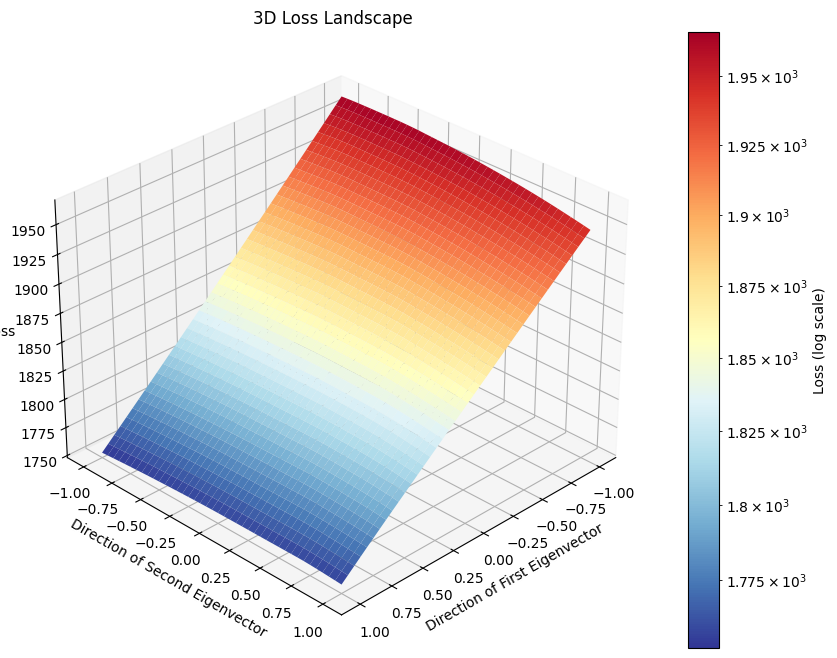

In [37]:
landscape.show()

X-axis range: 0.0, 1681.0
Y-axis range: 0.0, 1965.98046875


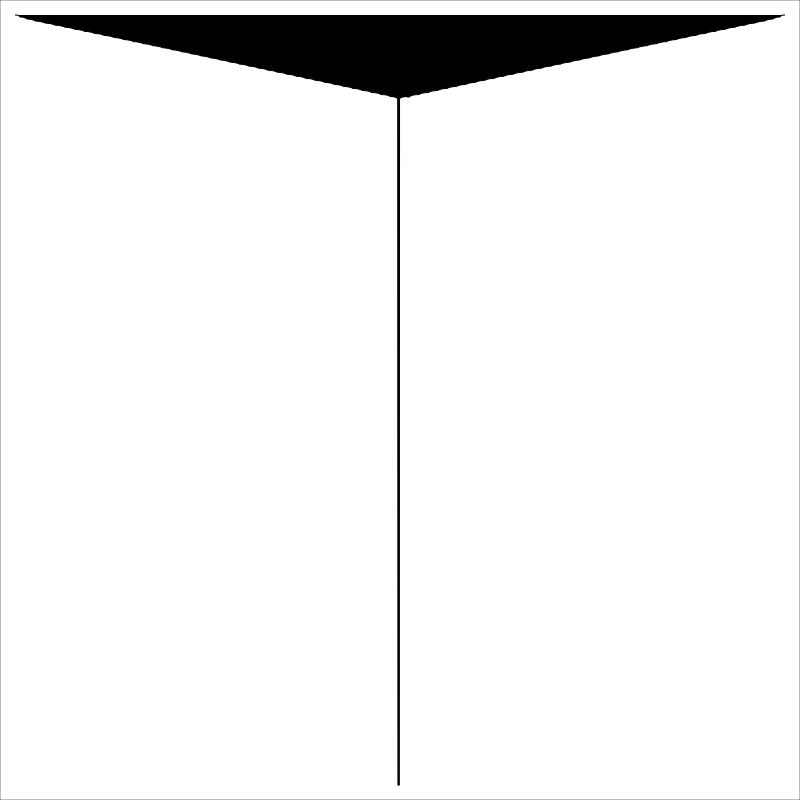

In [38]:
landscape.show_profile()

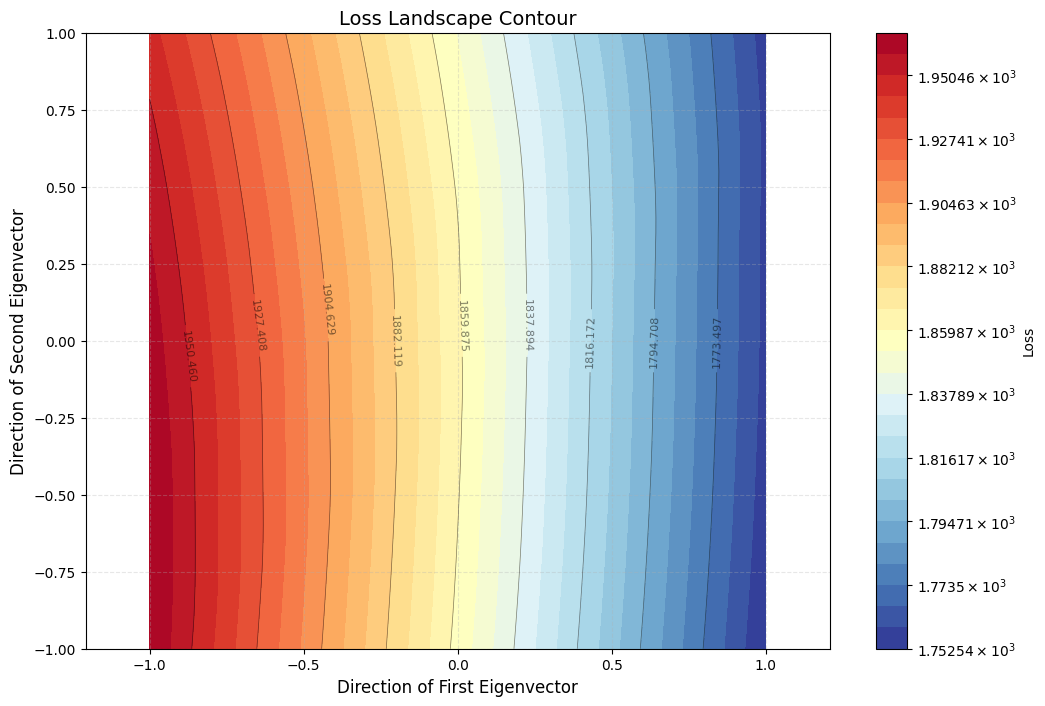

In [39]:
landscape.show_contour()

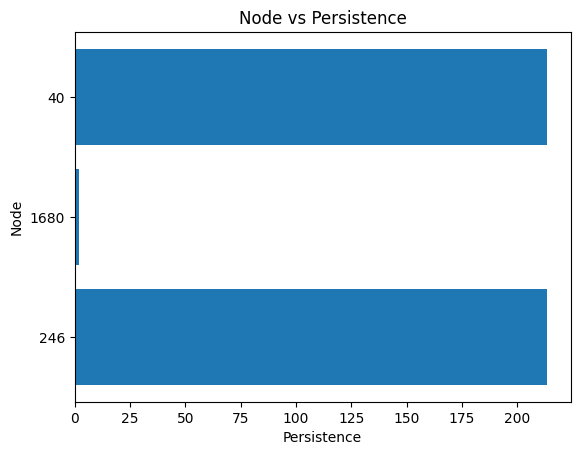

In [40]:
landscape.show_persistence_barcode()

In [41]:
# we can use this function to convert the merge tree 
# into a networkx graph and visualize it!
from landscaper.tda import merge_tree_to_nx
g = merge_tree_to_nx(landscape.get_sublevel_tree())

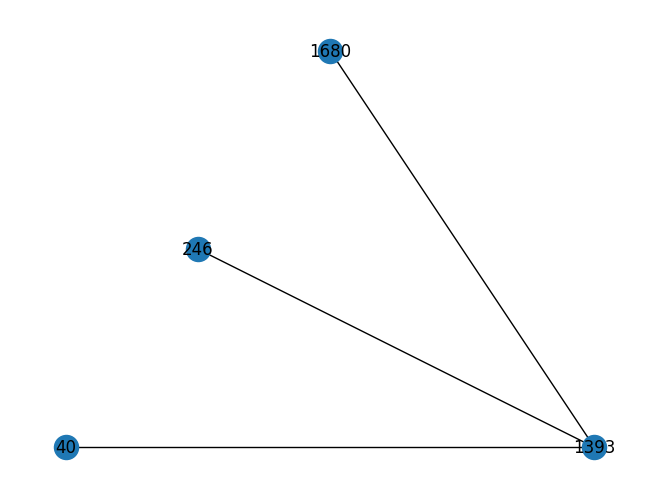

In [42]:
import networkx as nx
nx.draw_planar(g, with_labels=True)

In [4]:
landscape.smad()

3.52960205078125